Libaries 

In [1]:
import os
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



In [2]:
# stage 1 Dataset Selection:
base_dir = r"C:\Users\liory\Downloads\Stock Market Dataset"

print("stocks:", len(os.listdir(base_dir + r"\stocks")))
print("etfs:", len(os.listdir(base_dir + r"\etfs")))


stocks: 5884
etfs: 2165


In [3]:
import glob
stocks_dir = r"C:\Users\liory\Downloads\Stock Market Dataset\stocks"
etf_dir    = r"C:\Users\liory\Downloads\Stock Market Dataset\etfs"

stock_files = glob.glob(stocks_dir + r"\*.csv")
etf_files   = glob.glob(etf_dir   + r"\*.csv")

print("number of stock files:", len(stock_files))
print("number of ETF files:", len(etf_files))

df = pd.read_csv(stock_files[0])

number of stock files: 5884
number of ETF files: 2165


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5124 entries, 0 to 5123
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5124 non-null   datetime64[ns]
 1   Open       5124 non-null   float64       
 2   High       5124 non-null   float64       
 3   Low        5124 non-null   float64       
 4   Close      5124 non-null   float64       
 5   Adj Close  5124 non-null   float64       
 6   Volume     5124 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 280.3 KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


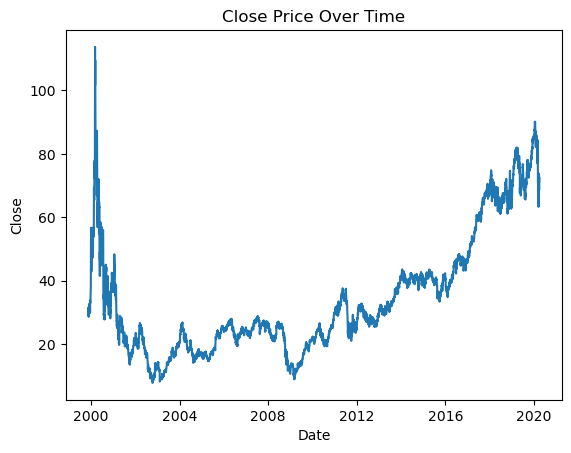

In [5]:
plt.figure()
plt.plot(df["Date"], df["Close"])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Close Price Over Time")
plt.show()


In [6]:
## stage 2 Build Model:
values = df[["Close"]].values.astype("float32")

n = len(values)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_vals = values[:train_end]
val_vals   = values[train_end:val_end]
test_vals  = values[val_end:]


scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_vals)
val_scaled   = scaler.transform(val_vals)
test_scaled  = scaler.transform(test_vals)

In [7]:
def make_windows(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 30

X_train, y_train = make_windows(train_scaled, SEQ_LEN)
X_val,   y_val   = make_windows(val_scaled, SEQ_LEN)
X_test,  y_test  = make_windows(test_scaled, SEQ_LEN)

print(X_train.shape, y_train.shape)


(3556, 30, 1) (3556, 1)


In [8]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  
        self.y = torch.tensor(y, dtype=torch.float32)  

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

xb, yb = next(iter(train_loader))
print("X batch:", xb.shape, "y batch:", yb.shape)


X batch: torch.Size([64, 30, 1]) y batch: torch.Size([64, 1])


In [9]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)     
        last = out[:, -1, :]    
        y = self.fc(last)          
        return y


In [10]:
class GRURegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)


In [ ]:
# stage 3 model train and test
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMRegressor(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad()

        preds = model(Xb)                
        loss = criterion(preds, yb)      

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * Xb.size(0)

    return total_loss / len(loader.dataset)

history = {"train_loss": [], "val_loss": []}
EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    train_loss = run_epoch(model, train_loader, train=True)
    val_loss   = run_epoch(model, val_loader, train=False)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")


Epoch 01/20 | train_loss=0.024022 | val_loss=0.004042
Epoch 02/20 | train_loss=0.014934 | val_loss=0.017762
Epoch 03/20 | train_loss=0.015081 | val_loss=0.025391
Epoch 04/20 | train_loss=0.013635 | val_loss=0.025186
Epoch 05/20 | train_loss=0.012748 | val_loss=0.023535
Epoch 06/20 | train_loss=0.012117 | val_loss=0.020939
Epoch 07/20 | train_loss=0.011287 | val_loss=0.016946
Epoch 08/20 | train_loss=0.009940 | val_loss=0.011090
Epoch 09/20 | train_loss=0.006799 | val_loss=0.002910
Epoch 10/20 | train_loss=0.015622 | val_loss=0.026772
Epoch 11/20 | train_loss=0.012822 | val_loss=0.029257
Epoch 12/20 | train_loss=0.011592 | val_loss=0.027039
Epoch 13/20 | train_loss=0.011104 | val_loss=0.025579
Epoch 14/20 | train_loss=0.010709 | val_loss=0.023748
Epoch 15/20 | train_loss=0.010136 | val_loss=0.020935
Epoch 16/20 | train_loss=0.009341 | val_loss=0.016069
Epoch 17/20 | train_loss=0.007850 | val_loss=0.007730
Epoch 18/20 | train_loss=0.005098 | val_loss=0.000200


In [ ]:
plt.figure()
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [ ]:
model.eval()

preds_list = []
y_list = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy()  
        preds_list.append(preds)
        y_list.append(yb.numpy())        

preds_scaled = np.vstack(preds_list)  
y_scaled     = np.vstack(y_list)      


In [ ]:
preds = scaler.inverse_transform(preds_scaled)
y_true = scaler.inverse_transform(y_scaled)


In [ ]:
rmse = np.sqrt(np.mean((preds - y_true) ** 2))
print("Test RMSE:", rmse)


In [ ]:
plt.figure()
plt.plot(y_true[:200], label="Actual")
plt.plot(preds[:200], label="Predicted")
plt.xlabel("Time step")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted (first 200 test points)")
plt.legend()
plt.show()


In [ ]:
#Report

Preprocessing:
I converted the Date column into a datetime format and sorted the dataset chronologically. Since this is a time-series task, I performed a time-based split into 70% training, 15% validation, and 15% testing, without shuffling to preserve temporal order.
For scaling, I used MinMaxScaler, fitting it only on the training set to prevent future data leakage, then transforming the validation and test sets using the same scaler.
After scaling, I generated sliding windows with seq_len=30, where each sample consists of 30 past time steps and the label represents the next value in the sequence.

Architecture:
I implemented an LSTM-based regressor with hidden_size=64, num_layers=2, and dropout=0.2 for regularization.
The final layer is a fully connected Linear unit that outputs a single predicted value for each input sequence.

Training & Validation:
The model was trained using MSELoss as the objective function and optimized with the Adam optimizer at a learning rate of lr=1e-3.
Training was performed with batch_size=64 for 20 epochs, evaluating performance on the validation set after each epoch to track loss improvement and avoid overfitting.

Results & Evaluation:
I logged training and validation loss values and visualized them using a train/val loss plot.
Final performance was evaluated on the test set using RMSE, and I also plotted Actual vs Predicted values over the first 200 test points to verify that the model follows the historical trend and produces reasonable future forecasts.